In [1]:
import numpy as np
import sfr_tomo as cib
import pyccl as ccl
import sacc
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d
from scipy.linalg import block_diag
import emcee
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

## Read constraints on $\langle b\rho_{\rm SFR}\rangle$

In [2]:
COSMO_P18 = {"Omega_c": 0.26066676,
             "Omega_b": 0.048974682,
             "h": 0.6766,
             "n_s": 0.9665,
             "sigma8": 0.8102}
cosmo = ccl.Cosmology(**COSMO_P18)

In [23]:
s = sacc.Sacc.load_fits("data/cls_cov_minimal_newcov.fits")
nms = [f'DELS__{i}' for i in range(4)]+[f'eBOSSQSO__{i}' for i in range(2)]
nz_data = [{'name': nm,
            'zs': s.tracers[nm].z,
            'nz': s.tracers[nm].nz/np.sum(s.tracers[nm].nz),
            'z_mean': np.average(s.tracers[nm].z, weights=s.tracers[nm].nz)}
           for nm in nms]
zs = np.array([d['z_mean'] for d in nz_data])

[0.21026038 0.38402575 0.51804074 0.65964767 1.18753879 1.82402459]
[-0.00565437  0.02606994  0.04083715  0.04814109  0.10998328  0.25961848]
[0.00867026 0.00584995 0.00521995 0.00532248 0.01348039 0.0317102 ]


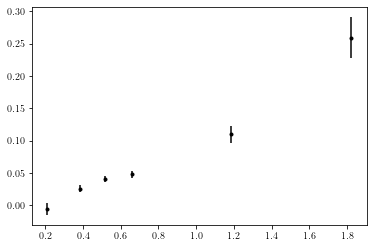

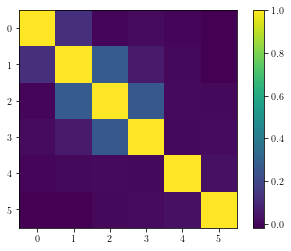

In [4]:
d = np.load("data/bSFR_kmax0p15_allbins_allfreq.npz")
data_bsfr = d['means']
cov_bsfr = d['cov']
#zs = d['zs']
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
print(zs)
print(data_bsfr)
print(np.sqrt(np.diag(cov_bsfr)))
icov_bsfr = np.linalg.inv(cov_bsfr)
plt.figure()
plt.imshow(cov_bsfr/np.sqrt(np.diag(cov_bsfr)[None, :]*np.diag(cov_bsfr)[:, None]))
plt.colorbar()

In [5]:
mdef = ccl.halos.MassDef200c()
cM = ccl.halos.ConcentrationDuffy08(mdef)
nM = ccl.halos.MassFuncTinker10(cosmo, mdef, norm_all_z=True)
bM = ccl.halos.HaloBiasTinker10(cosmo, mdef)
hmc = ccl.halos.HMCalculator(cosmo, nM, bM, mdef)

In [6]:
def get_pred_SFR(p, convolve=True, num_z=100, SFR=False, zmax=2.3):
    zz = np.linspace(0, zmax, num_z)
    M0, Mz, eps0, epsz = p
    pr.update_parameters(log10M0=M0, log10Mz=Mz,
                         eps0=eps0, epsz=epsz)
    if SFR:
        func = ccl.halos.halomod_mean_profile_1pt
    else:
        func = ccl.halos.halomod_bias_1pt
    bsfr = np.array([func(cosmo, hmc, 1E-4, 1/(1+z), pr)
                     for z in zz])
    if not convolve:
        return zz, bsfr
    bsfrf = interp1d(zz, bsfr, fill_value=0, bounds_error=False)
    bsfrt = np.array([np.average(bsfrf(b['zs']), weights=b['nz']) for b in nz_data])
    return bsfrt

In [7]:
import time
p0 = [11.34, 0.692, 0.005, 0.689]
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True, emerge=True)
niter = 5
start = time.time()
for i in range(niter):
    get_pred_SFR(p0, num_z=20)
end = time.time()
print((end-start)/niter)

start = time.time()
for i in range(niter):
    get_pred_SFR(p0, num_z=20)
end = time.time()
print((end-start)/niter)

0.01635127067565918
0.01591501235961914


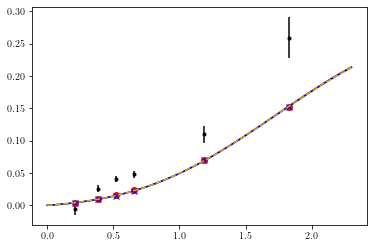

In [8]:
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
zhi = np.linspace(0, 2, 128)

p0 = [11.34, 0.692, 0.005, 0.689]
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=False, emerge=True)
bsfr = get_pred_SFR(p0)
plt.plot(zs, bsfr, 'ro')
zhi, bsfr = get_pred_SFR(p0, convolve=False)
plt.plot(zhi, bsfr, 'r-')

pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True, emerge=True)
bsfr = get_pred_SFR(p0)
plt.plot(zs, bsfr, 'bx')
zhi, bsfr = get_pred_SFR(p0, convolve=False)
plt.plot(zhi, bsfr, 'b-')
zhi, bsfr = get_pred_SFR(p0, convolve=False, num_z=20)
plt.plot(zhi, bsfr, 'y--')
plt.show()

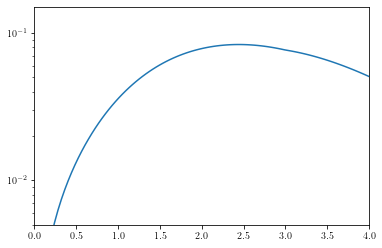

In [9]:
zhi, rsfr = get_pred_SFR(p0, convolve=False, num_z=100, SFR=True, zmax=4.0)
plt.plot(zhi, rsfr)
plt.xlim([0, 4])
plt.ylim([5E-3, 0.15])
plt.yscale('log')

In [10]:
pr = cib.HaloProfileCIBM21(cosmo, cM, fsub=0.134, fast_integ=True, emerge=True)
priors = [[9.0, 14.0], [-6, 6], [0.0, 1.0], [0.0, 1.0]]

def out_prior(p):
    for par, prior in zip(p, priors):
        if (par < prior[0]) or (par > prior[1]):
            return True
    return False

def chi2_bsfr(p):
    if out_prior(p):
        return np.inf
    th = get_pred_SFR(p, num_z=20)
    r = th - data_bsfr
    chi2 = np.dot(r, np.dot(icov_bsfr, r))
    return chi2

def like_bsfr(p):
    return -0.5*chi2_bsfr(p)

In [11]:
pBF = minimize(chi2_bsfr, p0, method='Powell').x
print(pBF)
print(chi2_bsfr(pBF))

/home/damonge/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2149: RuntimeWarning: invalid value encountered in double_scalars
  tmp2 = (x - v) * (fx - fw)
/home/damonge/.local/lib/python3.8/site-packages/scipy/optimize/optimize.py:2555: RuntimeWarning: invalid value encountered in double_scalars
  w = xb - ((xb - xc) * tmp2 - (xb - xa) * tmp1) / denom


[12.39504754 -0.99014768  0.05739485  0.99999919]
7.068783280301738


In [24]:
nwalkers = 8
npars = len(pBF)
nsteps = 10000

pos = (pBF +
       0.001 * np.random.randn(nwalkers, npars))
sampler = emcee.EnsembleSampler(nwalkers, npars, like_bsfr)
sampler.run_mcmc(pos, nsteps, progress=True)

  0%|          | 0/10000 [00:00<?, ?it/s]/home/damonge/.local/lib/python3.8/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 10000/10000 [16:06<00:00, 10.35it/s]


State([[ 1.01346570e+01  3.14568338e-01  9.75403237e-01  8.30909071e-01]
 [ 1.08266968e+01  1.39592791e+00  3.22848263e-01  8.54826798e-01]
 [ 1.18621667e+01  9.04421942e-02  2.94302633e-01  5.40658655e-01]
 [ 1.20241678e+01  9.87040123e-01  2.16303009e-03  9.65375180e-01]
 [ 1.02272281e+01  1.77813353e+00  6.80534208e-01  9.91028078e-02]
 [ 1.09848243e+01 -2.83680196e-01  6.19775664e-01  6.76125156e-01]
 [ 1.14650055e+01 -3.34995073e-01  2.67381362e-01  9.46087760e-01]
 [ 1.19475663e+01 -2.05955901e-02  3.88195931e-01  1.47242188e-01]], log_prob=[-4.54782995 -6.00428717 -4.74706748 -5.46363792 -7.02877772 -4.56473667
 -4.04640802 -9.08871323], blobs=None, random_state=('MT19937', array([4261380980, 4178192422,  767275450, 3940960612, 3051584598,
        523286045, 2960735794, 2118605011, 2348484945, 2911318363,
       1902626763, 2617034957, 1880341226,  398830699, 4010833262,
        792040760, 3080494068, 1096854113, 2672040636, 2767087613,
        259678593, 4151013712,  995314630,

In [12]:
fname_chain = "data/hm_constraints_kmax0p15_emerge.npz"

In [ ]:
chain = sampler.get_chain(discard=500, flat=True)
np.savez(fname_chain, chain=chain)

In [13]:
chain = np.load(fname_chain)['chain']

Removed no burn in


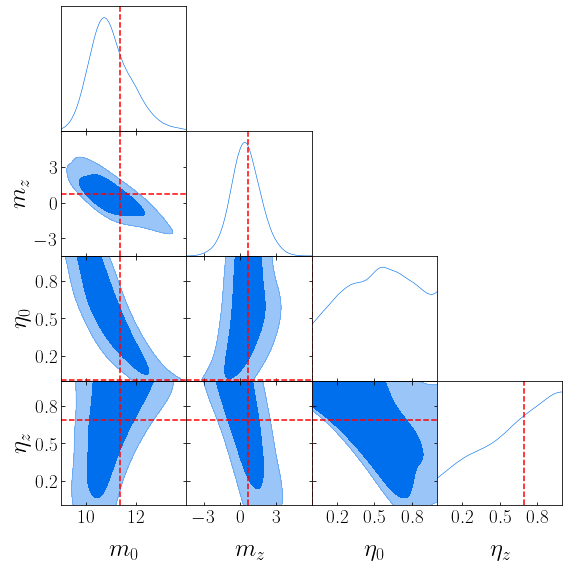

In [14]:
from getdist import MCSamples
from getdist import plots as gplots

chain = np.load(fname_chain)['chain']
nsamples = len(chain)
# Generate samples
samples = MCSamples(samples=chain,
                    names=['m0', 'mz', 'eta0', 'etaz'],
                    labels=[r'$m_0$',
                            r'$m_z$',
                            r'$\eta_0$',
                            r'$\eta_z$'],
                    ranges=priors)
samples.smooth_scale_2D=0.5

# Triangle plot
g = gplots.getSubplotPlotter()
g.settings.axis_marker_lw = 1.5
g.settings.axis_marker_color = 'r'
g.settings.axes_fontsize = 22
g.settings.axes_labelsize = 28
g.triangle_plot([samples], filled=True, markers={'m0': 11.339, 'mz': 0.692, 'eta0': 0.005, 'etaz': 0.689})
plt.savefig('constraints_B.pdf', bbox_inches='tight')

In [15]:
print(np.mean(chain, axis=0))
print(np.std(chain, axis=0))
for i, n in enumerate(['m0', 'mz', 'eta0', 'etaz']):
    print(samples.getInlineLatex(n, limit=1), np.std(chain[:, i]))

[11.00031244  0.48917038  0.52377706  0.6042666 ]
[0.84245312 1.26617935 0.27074477 0.27110841]


$m_0$ = 11.00^{+0.62}_{-0.99} 0.8424531246662982
$m_z$ = 0.5\pm 1.3 1.2661793464623265
$\eta_0$ = 0.52^{+0.35}_{-0.27} 0.2707447673388018
$\eta_z$ > 0.477 0.27110841253963236


In [17]:
pars = chain[np.random.choice(range(len(chain)), 1000)]
curves_bsfr = np.array([get_pred_SFR(p, convolve=False, num_z=25, zmax=2.5)[1] for p in pars])
curves_rsfr = np.array([get_pred_SFR(p, convolve=False, num_z=25, zmax=2.5, SFR=True)[1] for p in pars])

In [18]:
np.savez("sfr_curves_modelB.npz", zs=zhi, bsfr=curves_bsfr, sfrd=curves_rsfr)#

(6,) (6,)


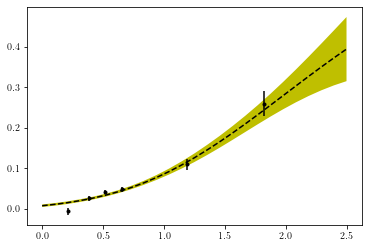

In [24]:
print(zs.shape, data_bsfr.shape)
bsfr_mean = np.mean(curves_bsfr, axis=0)
bsfr_std = np.std(curves_bsfr, axis=0)
zhi, bsfr_M21 = get_pred_SFR(p0, convolve=False, num_z=25, zmax=2.5)
plt.errorbar(zs, data_bsfr, yerr=np.sqrt(np.diag(cov_bsfr)), fmt='k.')
#plt.plot(zhi, bsfr_M21, 'r-')
plt.plot(zhi, bsfr_mean, 'k--')
plt.fill_between(zhi, bsfr_mean-bsfr_std, bsfr_mean+bsfr_std, facecolor='y')

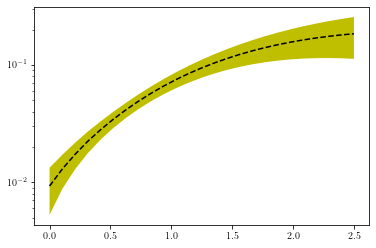

In [26]:
zhi, rsfr_M21 = get_pred_SFR(p0, convolve=False, num_z=25, zmax=2.5, SFR=True)
#plt.plot(zhi, rsfr_M21, 'r-')
rsfr_mean = np.mean(curves_rsfr, axis=0)
rsfr_std = np.std(curves_rsfr, axis=0)
plt.plot(zhi, rsfr_mean, 'k--')
plt.fill_between(zhi, rsfr_mean-rsfr_std, rsfr_mean+rsfr_std, facecolor='y')
plt.yscale('log')

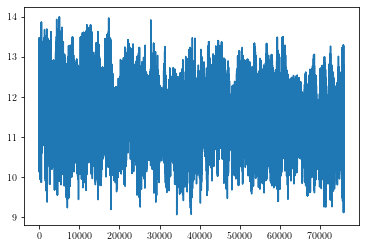

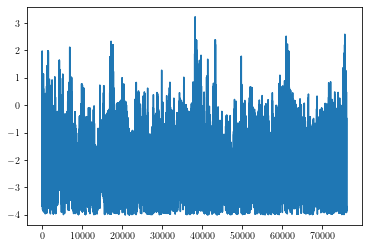

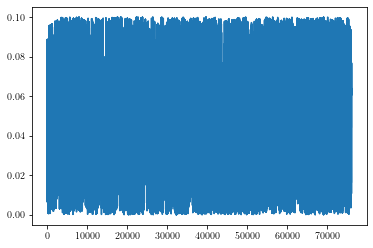

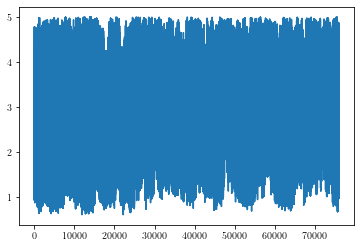

In [19]:
for c in chain.T:
    plt.figure()
    plt.plot(c)